In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings  
from sklearn.pipeline import Pipeline 
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, precision_score,recall_score,accuracy_score,f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate

In [2]:
filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
pd.set_option('display.float_format', lambda x: '%.2f' % x)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sreen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sreen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sreen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
df = pd.read_excel("amazon.xlsx")
df0 = df.copy() 


In [4]:
# Exploratory Data Analysis
def duplicate_values(df):
    print("Duplicate check...")
    num_duplicates = df.duplicated(subset=None, keep='first').sum()
    if num_duplicates > 0:
        print("There are", num_duplicates, "duplicated observations in the dataset.")
        df.drop_duplicates(keep='first', inplace=True)
        print(num_duplicates, "duplicates were dropped!")
        print("No more duplicate rows!")
    else:
        print("There are no duplicated observations in the dataset.")
        
duplicate_values(df)

Duplicate check...
There are 63 duplicated observations in the dataset.
63 duplicates were dropped!
No more duplicate rows!


In [5]:
print(df.info())
print(df.isna().mean().apply(lambda x: f"%{x*100:.2f}"))


<class 'pandas.core.frame.DataFrame'>
Index: 5548 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5548 non-null   int64 
 1   HelpFul  5548 non-null   int64 
 2   Title    5500 non-null   object
 3   Review   5534 non-null   object
dtypes: int64(2), object(2)
memory usage: 216.7+ KB
None
Star       %0.00
HelpFul    %0.00
Title      %0.87
Review     %0.25
dtype: object


In [7]:
class DataCleaner:
    def __init__(self, df):
        self.df = df

    def fill_missing_values(self):
        """
        Fills missing values in the 'Review' and 'Title' columns:
        - If 'Review' is missing but 'Title' exists, copy 'Title' to 'Review'.
        - If 'Title' is missing but 'Review' exists, copy 'Review' to 'Title'.
        - If both 'Review' and 'Title' are missing, drop the row.
        """
        # Fill missing 'Review' with 'Title' if available
        self.df.loc[self.df["Review"].isna() & self.df["Title"].notna(), "Review"] = self.df["Title"]

        # Fill missing 'Title' with 'Review' if available
        self.df.loc[self.df["Title"].isna() & self.df["Review"].notna(), "Title"] = self.df["Review"]

        # Drop rows where both 'Review' and 'Title' are missing
        self.df = self.df.dropna(subset=["Review", "Title"])

        return self.df

cleaner = DataCleaner(df)
df = cleaner.fill_missing_values()

In [9]:
def text_preprocessing(df, text_column, remove_rare_words=True, rare_word_count=1000):
    # Case Folding - Convert to lowercase
    df[text_column] = df[text_column].str.lower()
    
    # Remove punctuation
    df[text_column] = df[text_column].str.replace('[^\w\s]', '', regex=True)
    
    # Remove numbers
    df[text_column] = df[text_column].str.replace('\d+', '', regex=True)
    
    # Remove stopwords
    sw = set(stopwords.words('english'))
    df[text_column] = df[text_column].apply(
        lambda x: " ".join(word for word in str(x).split() if word not in sw)
    )
    
    # Remove rare words (optional)
    if remove_rare_words:
        sil = pd.Series(' '.join(df[text_column]).split()).value_counts()[-rare_word_count:]
        df[text_column] = df[text_column].apply(
            lambda x: " ".join(word for word in x.split() if word not in sil)
        )
    # Lemmatization - Reduce words to their base form
    df[text_column] = df[text_column].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 
    return df[text_column] 

print(text_preprocessing(df, 'Review'))
print(df[['Review']].head(10))


0                                                   happy
1                     good quality material however panel
2       product fun bedroom windowsbr imagery bit stre...
3                                    lo que e que un poco
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                                color way panel match
5608    great studio complement entire theme area phot...
5609                         brought beauty kid room love
5610        cute curtain son room thick enough keep light
Name: Review, Length: 5543, dtype: object
                                              Review
0                                              happy
1                good quality material however panel
2  product fun bedroom windowsbr imagery bit stre...
3                               lo que e que un poco
4  great bang buck cant believe quality material ...
5 

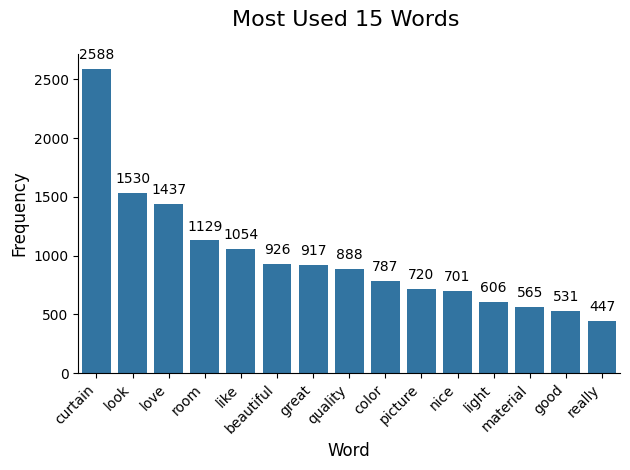

In [10]:
# Text Data Visualization
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]

top_words = tf.sort_values("tf", ascending=False).head(15) 

ax = sns.barplot(x="words", y="tf", data=top_words)

plt.title("Most Used 15 Words ", fontsize=16, pad=20)
plt.xlabel("Word", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=10)

sns.despine()
plt.tight_layout()
plt.show()

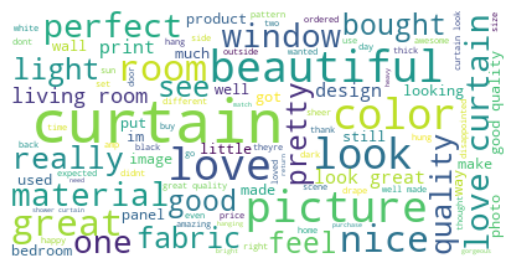

In [11]:
# Wordcloud
text = " ".join(i for i in df.Review)

wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [12]:
sia = SentimentIntensityAnalyzer() 

In [ ]:
def get_sentiment(text):
    scores = sia.polarity_scores(text)
    if scores["compound"] > 0:
        return "pos"
    elif scores["compound"] == 0:
        return "neutral"
    else:
        return "neg"

df["Sentiment_Label"] = df["Review"].apply(get_sentiment)


<Figure size 600x400 with 0 Axes>

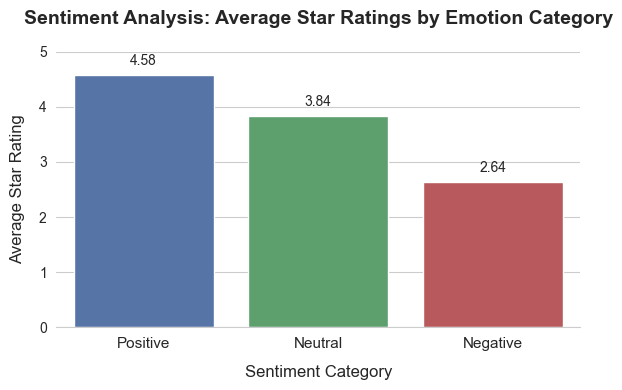

In [17]:

plt.figure(figsize=(6, 4))
sns.set_style("whitegrid")

ax = sns.barplot(data=df, 
                 x="Sentiment_Label", 
                 y="Star", 
                 estimator="mean",
                 palette={"pos": "#4c72b0", "neg": "#c44e52", "neutral": "#55a868"},
                 saturation=0.8,
                 ci=None)
plt.title("Sentiment Analysis: Average Star Ratings by Emotion Category", 
          fontsize=14, pad=20, fontweight='bold')
plt.xlabel("Sentiment Category", fontsize=12, labelpad=10)
plt.ylabel("Average Star Rating", fontsize=12, labelpad=10)
plt.ylim(0, 5)  # Assuming star ratings are 1-5 scale
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=10)

ax.set_xticklabels(["Positive", "Neutral", "Negative"], fontsize=11)

sns.despine(left=True)
plt.tight_layout()
plt.show()


In [18]:
print(df["Sentiment_Label"].value_counts())


Sentiment_Label
pos        4715
neutral     517
neg         311
Name: count, dtype: int64


In [19]:
# Train Test Split
X = df["Review"].values
y = df["Sentiment_Label"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2 ,random_state=42)

operations = [("vectorizer", TfidfVectorizer()), ("logistic", LogisticRegression(class_weight='balanced'))]

log_model = Pipeline(steps=operations)

log_model.fit(X_train, y_train) 

y_pred = log_model.predict(X_test)  
y_pred_proba = log_model.predict_proba(X_test) 


In [20]:
# Evaluate the metrics
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

eval_metric(log_model, X_train, y_train, X_test, y_test)

Test_Set
[[ 46   9   7]
 [  6  91   7]
 [ 50  43 850]]
              precision    recall  f1-score   support

         neg       0.45      0.74      0.56        62
     neutral       0.64      0.88      0.74       104
         pos       0.98      0.90      0.94       943

    accuracy                           0.89      1109
   macro avg       0.69      0.84      0.75      1109
weighted avg       0.92      0.89      0.90      1109


Train_Set
[[ 249    0    0]
 [   1  412    0]
 [ 123  147 3502]]
              precision    recall  f1-score   support

         neg       0.67      1.00      0.80       249
     neutral       0.74      1.00      0.85       413
         pos       1.00      0.93      0.96      3772

    accuracy                           0.94      4434
   macro avg       0.80      0.98      0.87      4434
weighted avg       0.96      0.94      0.94      4434

